In [1]:
import torch
from torch import Tensor
from torch import nn 
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
from utility import *

np.random.seed(seed=7)

In [2]:
import dlc_bci

train_input_100 , train_target_100 = dlc_bci.load(root = './data_bci_100Hz', download = False)
test_input_100 , test_target_100 = dlc_bci.load(root = './data_bci_100Hz', download = False, train = False)

train_input_1000 , train_target_1000 = dlc_bci.load(root = './data_bci_1000Hz', download = False, one_khz = True)
test_input_1000 , test_target_1000 = dlc_bci.load(root = './data_bci_1000Hz', download = False, train = False, one_khz = True)

print("Train input 100 Hz: {:d}x{:d}x{:d}".format(*(s for s in train_input_100.size())))
print("Train target 100 Hz: {:d}".format(*(s for s in train_target_100.size())))
print("Test input 100 Hz: {:d}x{:d}x{:d}".format(*(s for s in test_input_100.size())))
print("Test target 100 Hz: {:d}".format(*(s for s in test_target_100.size())))
print("")
print("Train input 1000 Hz: {:d}x{:d}x{:d}".format(*(s for s in train_input_1000.size())))
print("Train target 1000 Hz: {:d}".format(*(s for s in train_target_1000.size())))
print("Test input 1000 Hz: {:d}x{:d}x{:d}".format(*(s for s in test_input_1000.size())))
print("Test target 1000 Hz: {:d}".format(*(s for s in test_target_1000.size())))

Train input 100 Hz: 316x28x50
Train target 100 Hz: 316
Test input 100 Hz: 100x28x50
Test target 100 Hz: 100

Train input 1000 Hz: 316x28x500
Train target 1000 Hz: 316
Test input 1000 Hz: 100x28x500
Test target 1000 Hz: 100


# Network definition

This conv2d network is more inspired from a classic conv2d net that is used for image recognition 

In [3]:
from models import *

In [4]:
def compute_nb_errors(model, data_input, data_target, batch_size):
    nb_errors = 0
    Ndata = len(data_input[:, 0, 0, 0])
    model.eval()
    print('data_target', data_target.shape)
    print('data_input', data_input.shape)
    
    for b_start in range(0, Ndata, batch_size):
        bsize_eff = batch_size - max(0, b_start+batch_size-Ndata)  # boundary case
        batch_output = model.forward(data_input.narrow(0, b_start, bsize_eff))  # is Variable if data_input is Variable
        if len(list(batch_output.size()))>1 and batch_output.size(1) > 1:
            # as many ouputs as there are classes => select maximum output
            nb_err_batch = (batch_output.max(1)[1] != data_target.narrow(0, b_start, bsize_eff)).long().sum()
            # overflow problem if conversion to Long Int not performed, treated as short 1-byte int otherwise!!
        else:
            # output is a scalar in [0, 1]
            nb_err_batch = batch_output.round().sub(data_target.narrow(0, b_start, bsize_eff)).sign().abs().sum()
        
        nb_errors += nb_err_batch
    if isinstance(nb_errors, Variable):
        nb_errors = nb_errors.data[0]
    return nb_errors

# Preprocessing and Data Augmentation

In [5]:
import numpy as np

preprocessed_input_train, preprocessed_input_validation, preprocessed_input_train_target, preprocessed_input_validation_target, kept_channels_idx = preprocessing_train(train_input_1000, train_target_1000, subsampling_frequency='100Hz', window=False,denoize=False, addGaussianNoise=False, reduceChannels=False, cutEnd = False)
preprocessed_input_test, preprocessed_input_test_target  = preprocessing_test(test_input_1000, test_target_1000, kept_channels_idx, subsampling_frequency='100Hz', window=False,denoize = False, reduceChannels=False, cutEnd=False)

#Remove Noise
#preprocessed_input_train = denoisedSignals(preprocessed_input_train)
#preprocessed_input_validation = denoisedSignals(preprocessed_input_validation)
#preprocessed_input_test = denoisedSignals(preprocessed_input_test)
#add random noise
#preprocessed_input_train = whiteNoise(preprocessed_input_train)
#preprocessed_input_validation = whiteNoise(preprocessed_input_validation)
#preprocessed_input_test = whiteNoise(preprocessed_input_test)

print('train', preprocessed_input_train.shape)
print('test', preprocessed_input_test.shape)
print('validation', preprocessed_input_validation.shape)

labels_train = torch.from_numpy(preprocessed_input_train_target)
labels_test = torch.from_numpy(preprocessed_input_test_target)
labels_validation = torch.from_numpy(preprocessed_input_validation_target)

preprocessed_input_train = torch.from_numpy(preprocessed_input_train).float()
preprocessed_input_test = torch.from_numpy(preprocessed_input_test).float()
preprocessed_input_validation = torch.from_numpy(preprocessed_input_validation).float()

Ntrain = len(preprocessed_input_train[:,0,0])
Ntest = len(preprocessed_input_test[:,0,0])
Nvalidation = len(preprocessed_input_validation[:,0,0])

Nchannels = len(preprocessed_input_train[0,:,0])
Nsamples_100 = preprocessed_input_train.size(-1)

print('Ntrain = ', Ntrain)
print('Ntest = ', Ntest)
print('Nvalidation = ', Nvalidation)

train_input = Variable(preprocessed_input_train.view(Ntrain, 1, Nchannels, Nsamples_100))
validation_input = Variable(preprocessed_input_validation.view(Nvalidation, 1, Nchannels, Nsamples_100), requires_grad=False)
test_input = Variable(preprocessed_input_test.contiguous().view(Ntest, 1, Nchannels, Nsamples_100), requires_grad=False)

train (3000, 28, 50)
test (1000, 28, 50)
validation (160, 28, 50)
Ntrain =  3000
Ntest =  1000
Nvalidation =  160


# Network training and testing
Non-linearity: elu  


|criterion | optimizer | lr  | momentum | batch size | Nepochs | Train acc. | Test acc.|
|----------|-----------|-----|----------|------------|---------|------------|----------|
| BCE  | Adam  |1e-1 | def. | 15 | 150 | 86.4 | 61.4 | 
| BCE  | Adam  |1e-1 | def. | 20 | 150 | 99.8 | 79.5 | 
| BCE  | SGD   | 1e-2 | 0.85 | 20 | 150 | 98.9  | 61.5 | 
| CE   | Adam  | 1e-2 | def. | 20 | 150 | 98.4  |  70.5 | 
| CE   | SGD   | 1e-2 | 0.85 | 20 | 150 | 99.1 | 75.1 |


Non-linearity: ReLU

In [6]:
import torch.optim as optim
import math

# Train network 
criterion = nn.BCELoss()
#criterion = nn.CrossEntropyLoss()
#criterion = nn.PoissonNLLLoss()
#criterion = nn.BCEWithLogitsLoss()
#criterion = nn.SmoothL1Loss() #interesting ... but does not converge
#criterion = nn.MSELoss() #0.83 but unstable

if isinstance(criterion, nn.CrossEntropyLoss):
    train_target = Variable(labels_train)  # keep long tensors
    validation_target = Variable(labels_validation, requires_grad=False) # convert to float
    test_target = Variable(labels_test, requires_grad=False)
    Noutputs = 2
    
elif isinstance(criterion, nn.NLLLoss):
    train_target = Variable(labels_train)  # keep long tensors
    validation_target = Variable(labels_validation, requires_grad=False) # convert to float
    test_target = Variable(labels_test, requires_grad=False )
    Noutputs = 2
    
else:
    train_target = Variable(labels_train.float()) # convert to float
    validation_target = Variable(labels_validation.float(), requires_grad=False) # convert to float
    test_target = Variable(labels_test.float(), requires_grad=False)
    Noutputs = 1

batch_size = 15
Nbatches = int(math.ceil(Ntrain/batch_size))
Nepochs = 50
seeds = list(range(10))
#seeds = [14,20,21,22,27,46,44,37,31,28]
Nrep = len(seeds)

train_errors = torch.Tensor(Nrep, Nepochs).zero_()
test_errors = torch.Tensor(Nrep, Nepochs).zero_()
validation_errors = torch.Tensor(Nrep, Nepochs).zero_()
ep_loss = torch.Tensor(Nrep, Nepochs).zero_()

for i_rep in range(Nrep):    
    print('Repetition', seeds[i_rep])
    torch.manual_seed(seeds[i_rep])
    #model = conv2DNet_1(Noutputs) #from classic knowledge of image segmentation  
    #model = conv2DNet_2(Nchannels, Nsamples_100, Noutputs) #from litterature 
    #model = conv2DNet_3(Noutputs) #from Paper
    model = conv2DNet_4(Noutputs)  #from Temporal - Spatial; 4 Filters Model
    #model = conv2DNet_5(Noutputs) #from Temporal - Spatial; 64 Filters Model
    #model = conv2DNet_6(Noutputs) #from Temporal - Spatial; 128 Filters Model
    
    optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.50)
    #optimizer = optim.Adam(model.parameters())
    #optimizer = optim.Adagrad(model.parameters())
    #optimizer = optim.Adamax(model.parameters())
    #optimizer = optim.ASGD(model.parameters())
    #optimizer = optim.RMSprop(model.parameters())
    #optimizer = optim.Rprop(model.parameters())
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True)

    for i_ep in range(Nepochs):
        for b_start in range(0, Ntrain, batch_size):
            bsize_eff = batch_size - max(0, b_start+batch_size-Ntrain)  # boundary case
            model.train()
            model.zero_grad()
            output = model(train_input.narrow(0, b_start, bsize_eff))
            batch_loss = criterion(output, train_target.narrow(0, b_start, bsize_eff))            
            ep_loss[i_rep, i_ep] += batch_loss.data[0]
            batch_loss.backward()
            optimizer.step()
        
        scheduler.step(ep_loss[i_rep, i_ep])
        
        nb_train_errs = compute_nb_errors(model, train_input, train_target, batch_size)
        nb_validation_errs = compute_nb_errors(model, validation_input, validation_target, batch_size)
        nb_test_errs = compute_nb_errors(model, test_input, test_target, batch_size)
        
        print("Epoch Number : ", i_ep)
        print("\t Training accuracy: ", (100*(Ntrain-nb_train_errs)/Ntrain))
        print("\t Validation accuracy ",(100*(Nvalidation-nb_validation_errs)/Nvalidation)) 
        print("\t Test accuracy ",(100*(Ntest-nb_test_errs)/Ntest))
        
        print("\t Epoch Loss ", ep_loss[i_rep, i_ep])
        
        train_errors[i_rep, i_ep] = nb_train_errs
        test_errors[i_rep, i_ep] = nb_test_errs
        validation_errors[i_rep, i_ep] = nb_validation_errs

Repetition 0
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  0
	 Training accuracy:  49.0
	 Validation accuracy  62.5
	 Test accuracy  50.9
	 Epoch Loss  140.30462646484375
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  1
	 Training accuracy:  51.53333333333333
	 Validation accuracy  62.5
	 Test accuracy  48.8
	 Epoch Loss  138.38902282714844
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  2
	 Training accuracy:  55.266666666666666
	 Validation accu

Epoch Number :  23
	 Training accuracy:  86.33333333333333
	 Validation accuracy  80.625
	 Test accuracy  77.7
	 Epoch Loss  74.8979721069336
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  24
	 Training accuracy:  86.86666666666666
	 Validation accuracy  80.625
	 Test accuracy  77.8
	 Epoch Loss  71.85267639160156
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  25
	 Training accuracy:  87.46666666666667
	 Validation accuracy  81.25
	 Test accuracy  77.0
	 Epoch Loss  68.79740905761719
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
dat

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  47
	 Training accuracy:  92.06666666666666
	 Validation accuracy  75.625
	 Test accuracy  80.0
	 Epoch Loss  34.15172576904297
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  48
	 Training accuracy:  92.33333333333333
	 Validation accuracy  75.625
	 Test accuracy  80.0
	 Epoch Loss  32.465728759765625
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  49
	 Training accuracy:  92.33333333333333
	 Validation

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  20
	 Training accuracy:  88.46666666666667
	 Validation accuracy  70.0
	 Test accuracy  77.6
	 Epoch Loss  62.29459762573242
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  21
	 Training accuracy:  88.9
	 Validation accuracy  70.0
	 Test accuracy  78.7
	 Epoch Loss  58.692771911621094
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  22
	 Training accuracy:  89.33333333333333
	 Validation accuracy  71.875
	 Test accuracy  78.7
	 Epoch Loss  55.61451721191406
data_target torch

Epoch Number :  43
	 Training accuracy:  94.03333333333333
	 Validation accuracy  75.0
	 Test accuracy  79.0
	 Epoch Loss  24.20834732055664
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  44
	 Training accuracy:  94.03333333333333
	 Validation accuracy  78.125
	 Test accuracy  79.0
	 Epoch Loss  23.17477798461914
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  45
	 Training accuracy:  94.33333333333333
	 Validation accuracy  78.125
	 Test accuracy  78.9
	 Epoch Loss  22.127593994140625
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
da

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  17
	 Training accuracy:  86.83333333333333
	 Validation accuracy  70.625
	 Test accuracy  82.0
	 Epoch Loss  76.1814193725586
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  18
	 Training accuracy:  87.36666666666666
	 Validation accuracy  71.25
	 Test accuracy  81.7
	 Epoch Loss  72.63279724121094
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  19
	 Training accuracy:  88.06666666666666
	 Validation ac

Epoch Number :  40
	 Training accuracy:  93.13333333333334
	 Validation accuracy  66.25
	 Test accuracy  80.2
	 Epoch Loss  26.946760177612305
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  41
	 Training accuracy:  93.76666666666667
	 Validation accuracy  68.75
	 Test accuracy  80.5
	 Epoch Loss  25.977153778076172
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  42
	 Training accuracy:  94.0
	 Validation accuracy  68.125
	 Test accuracy  80.5
	 Epoch Loss  25.06134796142578
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target to

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  14
	 Training accuracy:  79.06666666666666
	 Validation accuracy  64.375
	 Test accuracy  74.5
	 Epoch Loss  100.50341796875
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  15
	 Training accuracy:  79.8
	 Validation accuracy  64.375
	 Test accuracy  77.5
	 Epoch Loss  96.37247467041016
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  16
	 Training accuracy:  79.63333333333334
	 Validation accuracy  56.25

Epoch Number :  37
	 Training accuracy:  92.0
	 Validation accuracy  68.75
	 Test accuracy  81.2
	 Epoch Loss  42.82660675048828
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  38
	 Training accuracy:  92.3
	 Validation accuracy  70.0
	 Test accuracy  80.6
	 Epoch Loss  41.39942932128906
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  39
	 Training accuracy:  92.3
	 Validation accuracy  70.0
	 Test accuracy  81.2
	 Epoch Loss  40.13179016113281
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input tor

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  11
	 Training accuracy:  70.1
	 Validation accuracy  58.125
	 Test accuracy  52.0
	 Epoch Loss  131.9694366455078
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  12
	 Training accuracy:  72.5
	 Validation accuracy  56.25
	 Test accuracy  58.5
	 Epoch Loss  129.24710083007812
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  13
	 Training accuracy:  73.66666666666667
	 Validation accuracy  52.5
	 Test accu

Epoch Number :  34
	 Training accuracy:  91.46666666666667
	 Validation accuracy  79.375
	 Test accuracy  79.5
	 Epoch Loss  57.19452667236328
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  35
	 Training accuracy:  91.66666666666667
	 Validation accuracy  80.0
	 Test accuracy  79.3
	 Epoch Loss  54.82395553588867
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  36
	 Training accuracy:  92.0
	 Validation accuracy  80.0
	 Test accuracy  78.8
	 Epoch Loss  52.7259521484375
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.S

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  8
	 Training accuracy:  61.833333333333336
	 Validation accuracy  45.625
	 Test accuracy  44.7
	 Epoch Loss  134.31224060058594
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  9
	 Training accuracy:  62.4
	 Validation accuracy  47.5
	 Test accuracy  44.6
	 Epoch Loss  133.66090393066406
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  10
	 Training accuracy:  62.63333333333333
	 Validation accuracy  43.1

Epoch Number :  31
	 Training accuracy:  87.26666666666667
	 Validation accuracy  81.25
	 Test accuracy  77.4
	 Epoch Loss  82.1185531616211
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  32
	 Training accuracy:  87.76666666666667
	 Validation accuracy  81.875
	 Test accuracy  79.0
	 Epoch Loss  78.04097747802734
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  33
	 Training accuracy:  88.4
	 Validation accuracy  83.125
	 Test accuracy  78.5
	 Epoch Loss  74.38348388671875
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torc

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  5
	 Training accuracy:  58.53333333333333
	 Validation accuracy  43.75
	 Test accuracy  44.1
	 Epoch Loss  133.748779296875
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  6
	 Training accuracy:  60.86666666666667
	 Validation accuracy  43.75
	 Test accuracy  44.6
	 Epoch Loss  132.31121826171875
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  7
	 Training accuracy:  62.733333333333334
	 Validation accu

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  28
	 Training accuracy:  89.9
	 Validation accuracy  58.75
	 Test accuracy  73.8
	 Epoch Loss  60.061370849609375
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  29
	 Training accuracy:  89.96666666666667
	 Validation accuracy  61.25
	 Test accuracy  75.1
	 Epoch Loss  57.005638122558594
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  30
	 Training accuracy:  89.83333333333333
	 Validation accuracy  58.75
	 Test accuracy  75.9
	 Epoch Loss  54.278194427490234
data_target to

Epoch Number :  1
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  141.36790466308594
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  2
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  140.23423767089844
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  3
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  139.33151245117188
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torc

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  25
	 Training accuracy:  85.73333333333333
	 Validation accuracy  78.75
	 Test accuracy  67.8
	 Epoch Loss  89.0241470336914
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  26
	 Training accuracy:  86.66666666666667
	 Validation accuracy  80.0
	 Test accuracy  69.8
	 Epoch Loss  82.98468017578125
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  27
	 Training accuracy:  87.56666666666666
	 Validation accu

Epoch Number :  48
	 Training accuracy:  95.06666666666666
	 Validation accuracy  75.0
	 Test accuracy  75.6
	 Epoch Loss  24.81014060974121
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  49
	 Training accuracy:  95.4
	 Validation accuracy  75.0
	 Test accuracy  75.5
	 Epoch Loss  23.230615615844727
Repetition 8
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  0
	 Training accuracy:  49.0
	 Validation accuracy  62.5
	 Test accuracy  51.0
	 Epoch Loss  144.0025177001953
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Si

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  22
	 Training accuracy:  84.8
	 Validation accuracy  74.375
	 Test accuracy  71.9
	 Epoch Loss  98.4433364868164
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  23
	 Training accuracy:  86.03333333333333
	 Validation accuracy  73.75
	 Test accuracy  74.1
	 Epoch Loss  94.00006866455078
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  24
	 Training accuracy:  86.7
	 Validation accuracy  73.75
	 Test accur

Epoch Number :  45
	 Training accuracy:  93.5
	 Validation accuracy  81.25
	 Test accuracy  79.3
	 Epoch Loss  34.84873962402344
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  46
	 Training accuracy:  93.23333333333333
	 Validation accuracy  81.875
	 Test accuracy  79.6
	 Epoch Loss  33.71274185180664
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  47
	 Training accuracy:  93.7
	 Validation accuracy  83.125
	 Test accuracy  79.4
	 Epoch Loss  32.7140998840332
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000]

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  19
	 Training accuracy:  85.53333333333333
	 Validation accuracy  51.875
	 Test accuracy  77.1
	 Epoch Loss  95.45995330810547
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  20
	 Training accuracy:  88.83333333333333
	 Validation accuracy  53.75
	 Test accuracy  77.3
	 Epoch Loss  87.96099853515625
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  21
	 Training accuracy:  89.03333333333333
	 Validation a

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  42
	 Training accuracy:  95.36666666666666
	 Validation accuracy  70.0
	 Test accuracy  77.3
	 Epoch Loss  24.01167869567871
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  43
	 Training accuracy:  93.5
	 Validation accuracy  66.875
	 Test accuracy  77.8
	 Epoch Loss  22.611862182617188
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  44
	 Training accuracy:  94.83333333333333
	 Validation accuracy  69.375
	 Test accuracy  77.5
	 Epoch Loss  21.600133895874023
data_target to

torch.Size([10, 50])
0


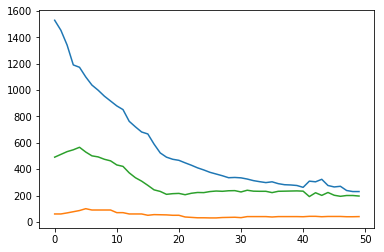

1


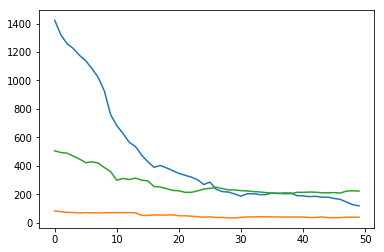

2


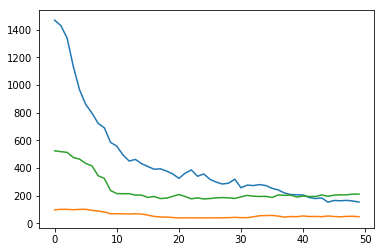

3


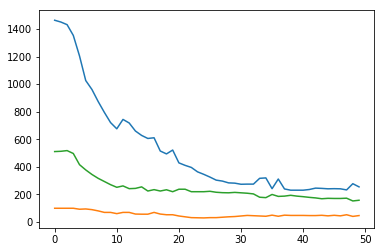

4


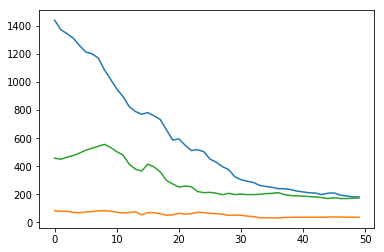

5


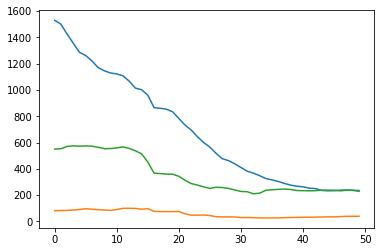

6


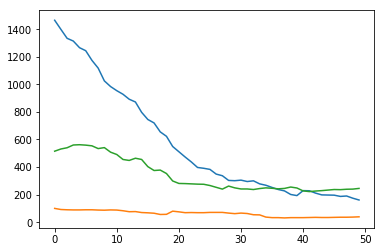

7


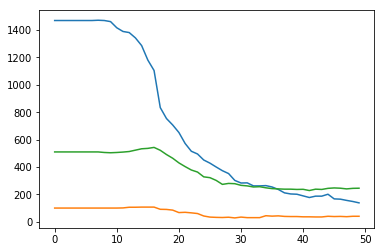

8


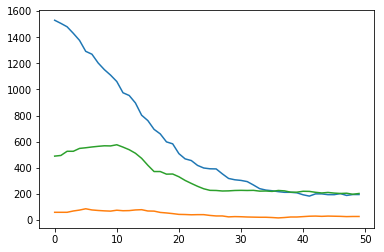

9


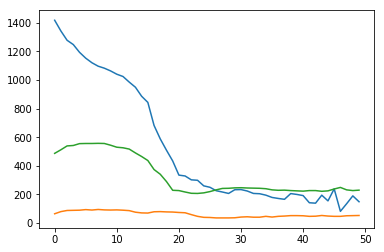

In [7]:
print(train_errors.shape)

for i_rep in range(Nrep):
    print(i_rep)
    plt.plot(np.array(train_errors[i_rep, :]))
    plt.plot(np.array(validation_errors[i_rep, :]))
    plt.plot(np.array(test_errors[i_rep, :]))
    plt.show()

0


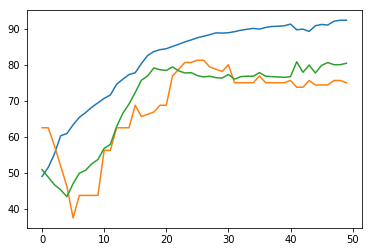

1


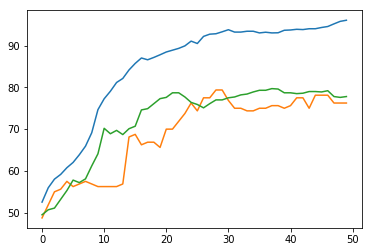

2


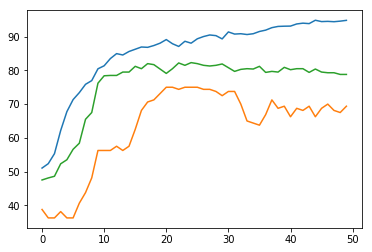

3


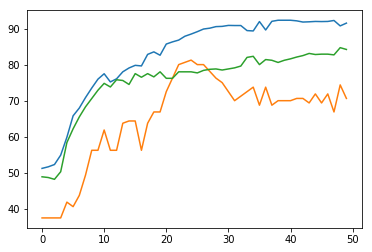

4


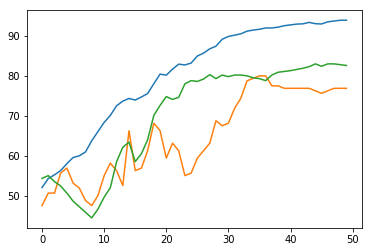

5


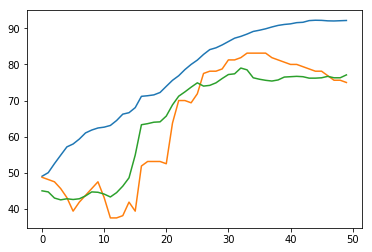

6


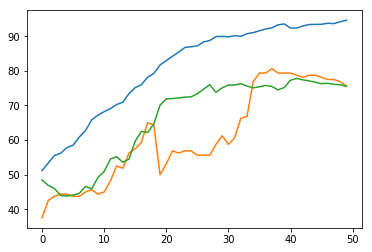

7


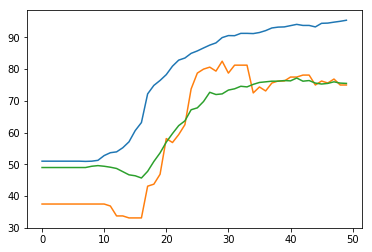

8


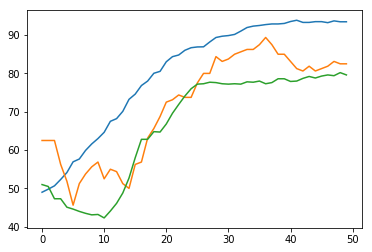

9


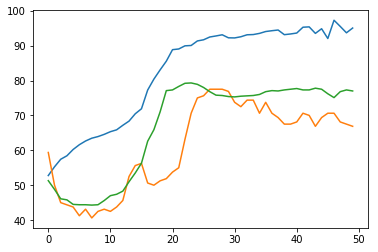

In [8]:
for i_rep in range(Nrep):
    print(i_rep)
    plt.plot(100*(Ntrain-np.array(train_errors[i_rep, :]))/Ntrain)
    plt.plot(100*(Nvalidation-np.array(validation_errors[i_rep, :]))/Nvalidation)
    plt.plot(100*(Ntest-np.array(test_errors[i_rep, :]))/Ntest)

    plt.show()

(50,)
Training accuracy 93.9%+-1.4502452611923218
Validation accuracy 74.3%+-4.168801307678223
Testing accuracy 78.8%+-2.7510898113250732


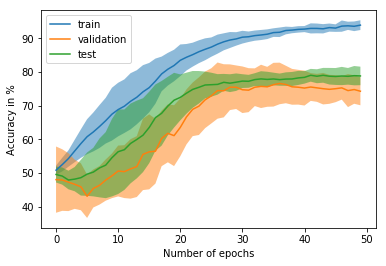

In [9]:
train_accuracy = 100*(Ntrain-np.array(train_errors))/Ntrain
val_accuracy = 100*(Nvalidation-np.array(validation_errors))/Nvalidation
test_accuracy = 100*(Ntest-np.array(test_errors))/Ntest

stddev_train_errors = np.std(train_accuracy, axis=0)
stddev_val_errors = np.std(val_accuracy, axis=0)
stddev_test_errors = np.std(test_accuracy, axis=0)

mean_train_errors = np.mean(train_accuracy, axis=0)
mean_val_errors = np.mean(val_accuracy, axis=0)
mean_test_errors = np.mean(test_accuracy, axis=0)

epoch = list(range(50))
print(stddev_train_errors.shape)

#plt.errorbar(epoch, mean_train_errors, stddev_train_errors)
#plt.errorbar(epoch, mean_val_errors, stddev_val_errors)
#plt.errorbar(epoch, mean_test_errors, stddev_test_errors)

plt.plot(epoch, mean_train_errors)
plt.plot(epoch, mean_val_errors)
plt.plot(epoch, mean_test_errors)
plt.fill_between(epoch, mean_train_errors+stddev_train_errors, mean_train_errors-stddev_train_errors, alpha=0.5)
plt.fill_between(epoch, mean_val_errors+stddev_val_errors, mean_val_errors-stddev_val_errors, alpha=0.5)
plt.fill_between(epoch, mean_test_errors+stddev_test_errors, mean_test_errors-stddev_test_errors, alpha=0.5)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy in %')
plt.legend(['train', 'validation', 'test'])

print("Training accuracy {:4.3g}%+-{}".format(mean_train_errors[-1], stddev_train_errors[-1]))
print("Validation accuracy {:4.3g}%+-{}".format(mean_val_errors[-1], stddev_val_errors[-1]))
print("Testing accuracy {:4.3g}%+-{}".format(mean_test_errors[-1], stddev_test_errors[-1]))